<a href="https://colab.research.google.com/github/zhuhadar/ai-summer-2025/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Summer 2025 - Retrieval Augmented Generation, LangChain, and Memory Management

## Introduction to Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is an architecture that enhances large language models (LLMs) by providing them with relevant information retrieved from external sources. Rather than relying solely on the model's internal knowledge, RAG allows the model to "look up" information before generating a response, improving accuracy and reducing hallucinations.

The core workflow consists of:

1. **Ingestion**: Loading documents and splitting them into manageable chunks
2. **Embedding**: Converting each chunk into a vector representation that captures its semantic meaning
3. **Retrieval**: Finding the most relevant chunks based on a user query
4. **Generation**: Using the retrieved information to inform the model's response

Throughout this notebook, we'll build a comprehensive RAG application using LangChain and LangGraph, with a focus on maintaining conversation memory across multiple interactions.

## LangChain Framework Overview

LangChain is a framework designed for developing applications powered by large language models. It provides standardized interfaces for working with LLMs and related technologies, along with pre-built components that can be assembled to create sophisticated applications.

The LangChain ecosystem consists of several core components:

- **langchain-core**: Base abstractions for chat models and other foundational components
- **Integration packages** (e.g., langchain-openai, langchain-anthropic): Lightweight packages for specific model providers
- **langchain**: Higher-level components like chains, agents, and retrieval strategies
- **langchain-community**: Third-party integrations maintained by the community
- **langgraph**: Orchestration framework for combining components into production-ready applications

Let's start by installing the necessary packages and setting up our environment:

In [1]:
#Install necessary packages

!pip install langchain langchain-core langchain-community langchain-openai streamlit langgraph bs4 pypdf langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.4

In [7]:
# Set up environment variables
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

# Google API Key

os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

OpenAI API Key:··········
Enter API key for Google Gemini: ··········


### Working with Language Models

LangChain provides a consistent interface for working with different language models. Let's initialize an OpenAI model and test it with a simple request:


In [8]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage

# Initialize the model
model = init_chat_model("gpt-4o", model_provider="openai")

# Create a simple conversation
messages = [
    SystemMessage("Translate the following from English into Italian. Provide no additional text."),
    HumanMessage("hi!"),
]

# Generate a response
response = model.invoke(messages)
print(response.content)

ciao!


In [10]:
# Initialize the model
google_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

# Create a simple conversation
messages = [
    SystemMessage("Translate the following from English into Italian. Provide no additional text."),
    HumanMessage("hi!"),
]

# Generate a response
response = google_model.invoke(messages)
print(response.content)

Ciao!


### Prompt Templates

Prompt templates are a powerful concept in LangChain that help structure inputs to language models. They allow you to create reusable patterns for prompts, with placeholders that can be filled in dynamically.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

# Create a template with placeholders
system_template = "Translate the following from English into {language}"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", "{text}")]
)

# Use the template to create a specific prompt
prompt = prompt_template.invoke({"language": "Italian", "text": "hi!"})
print(prompt)

# Pass the prompt to the model
response = model.invoke(prompt)
print(response.content)

messages=[SystemMessage(content='Translate the following from English into Italian', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi!', additional_kwargs={}, response_metadata={})]
Ciao! Sei addestrato su dati fino a ottobre 2023.


Prompt templates become particularly valuable when building complex applications where you need to maintain consistent prompt structures while varying the inputs.

## Adding Conversation Memory

A major limitation of basic LLM interactions is the lack of memory between requests. Each time you send a message, the model has no knowledge of previous exchanges. Let's demonstrate this limitation:

In [13]:
print(model.invoke([HumanMessage(content="Hi! I'm Umang")]).content)

Hello Umang! How can I assist you today?


In [14]:
print(model.invoke([HumanMessage(content="What is my Name?")]).content)

I'm sorry, I can't determine your name.


As you can see, the model doesn't remember the name that was mentioned in the first message. To create a proper conversational agent, we need to implement memory management. This is where LangGraph comes in.

### Understanding LangGraph

LangGraph is a framework for building stateful, multi-step workflows with LLMs. It uses a graph-based approach where:

1. **Nodes** represent individual processing steps (like calling an LLM or performing a retrieval step)
2. **Edges** define the flow between these steps
3. **State** carries information between nodes during execution

The key concept in LangGraph is the `StateGraph`, which defines how information flows through your application.

Let's build a simple conversational agent with memory:

In [15]:
# Enable LangSmith for tracking (optional but useful for debugging)
#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [16]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
new_graph = StateGraph(state_schema=MessagesState)

# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

# Define the (single) node in the graph
new_graph.add_edge(START, "model")
new_graph.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = new_graph.compile(checkpointer=memory)

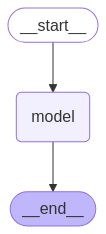

In [17]:
app

Let's break down what's happening here:

1. We create a `StateGraph` using the predefined `MessagesState` schema, which manages our conversation messages
2. We define a `call_model` function that takes the current state (messages) and returns an updated state with the model's response
3. We add this function as a node in our graph, connecting it to the `START` point
4. We add a `MemorySaver` to store conversation state between turns
5. We compile the graph into an executable application

Now let's test our conversational agent:

In [18]:
# Configuration with a conversation thread ID
config = {"configurable": {"thread_id": "first_conversation"}}

The `thread_id` in the configuration is crucial as it allows us to maintain separate conversations for different users.

In [19]:
# First message
query = "Hi! I'm Umang."
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello, Umang! How can I assist you today?


In [20]:
# Follow-up question - now the model should remember
query = "What is my name?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Umang. How can I assist you further?


The conversational agent is now able to keep track of the conversation across turns. Let's try a new conversation thread:

In [21]:
config = {"configurable": {"thread_id": "new_conversation"}}
input_messages = [HumanMessage(query)] #Using the same query - "What is my name?"
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, I can't know your name.


### Enhancing Our Agent with Custom System Prompts

Let's enhance our agent by adding a custom system prompt:

In [22]:
from langchain_core.prompts import MessagesPlaceholder

system_template = "You talk like a pirate. Answer all questions to the best of your ability."

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_template),
        MessagesPlaceholder(variable_name="messages"),  # Includes the conversation history
    ]
)

The `MessagesPlaceholder` is a special component that allows us to insert the conversation history into our prompt.

In [23]:
pirate_bot = StateGraph(state_schema=MessagesState)

# Prior call_model definition - one small change allows for a custom system prompt
#def call_model(state: MessagesState):
#    response = model.invoke(state["messages"])
#    return {"messages": response}

# Updated call_model defition
def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}

pirate_bot.add_edge(START, "model")
pirate_bot.add_node("model", call_model)

memory = MemorySaver()
app = pirate_bot.compile(checkpointer=memory)

In [24]:
# Test the pirate-talking agent
config = {"configurable": {"thread_id": "pirate"}}
query = "Hi! I'm Umang."
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ahoy, Umang! Welcome aboard! How can this salty sea dog be of service to ye today? 🤙🏼☠️


In [25]:
# Check memory
query = "What is my name?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ye just shared yer name with me, matey! It's Umang, if I'm recallin' correctly. How can I help ye further on this fine voyage? 🏴‍☠️


### Working with Complex State

For more complex applications, we often need to track additional information beyond just messages. Let's create a workflow that remembers the user's preferred language:

In [26]:
translator_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [27]:
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

# Define a custom state class
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

The State class defined in this approach is a custom state schema defined using Python's ```TypedDict```. It acts as a structured blueprint for the state that will flow through the graph in a LangGraph application.

**Components**:

- ```Sequence[BaseMessage]```

  A sequence of messages used in the conversation, such as ```HumanMessage```, ```AIMessage```, etc., from LangChain.

- ```Annotated[..., add_messages]```

  This annotation tells the graph to automatically append new messages to the existing list as state updates are returned. This is critical for tracking conversation history across nodes.  

- ```language: str```

  Stores the language preference of the user (e.g., "French", "English").
This is used downstream to influence how the prompt is generated or how the model response is crafted.

This pattern becomes especially important when building complex RAG applications, as we'll see next.

In [28]:
# Create a graph with this state schema
translator = StateGraph(state_schema=State)

# Define a function that respects the language preference
def call_model(state: State):
    prompt = translator_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

# Define nodes and edges
translator.add_edge(START, "model")
translator.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = translator.compile(checkpointer=memory)

In [29]:
# Test with a language preference
config = {"configurable": {"thread_id": "translation"}}
query = "Hi! I'm Umang."
language = "French"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Bonjour Umang ! Comment puis-je vous aider aujourd'hui ?


## Building a Complete RAG System

Now that we understand the basics of LangChain and LangGraph, let's build a complete RAG system that can answer questions based on web content. This system will:

1. Load content from a webpage
2. Split it into manageable chunks
3. Create vector embeddings for each chunk
4. Retrieve relevant chunks based on user queries
5. Generate responses that reference the retrieved information
6. Maintain conversation context across multiple turns

In [30]:
# Import necessary packages
import bs4
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.messages import HumanMessage
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

In [31]:
# --- Step 1: Initialize model and vector store components ---

# Load the LLM (chat model) – in this case, OpenAI's GPT-4o-mini
model = init_chat_model("gpt-4o-mini", model_provider="openai")
#model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

# Embedding model used to convert text into vector representations
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# In-memory vector store to hold document embeddings (can be replaced with Chroma, FAISS, etc.)
vector_store = InMemoryVectorStore(embeddings)

In [32]:
# --- Step 2: Load and process web content ---

# Load a webpage using BeautifulSoup and restrict parsing to certain HTML classes
loader = WebBaseLoader(
    web_paths=["https://lilianweng.github.io/posts/2023-06-23-agent/"],
    bs_kwargs={"parse_only": bs4.SoupStrainer(class_=["post-content", "post-title", "post-header"])},
)

# Load content into LangChain document format
docs = loader.load()

# Split the documents into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Add the document chunks to the vector store (they are embedded during this step)
_ = vector_store.add_documents(splits)

In [33]:
# --- Step 3: Define the prompt template ---

# This template combines retrieved context with the conversation history
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Use the context below to answer the question concisely.\n\nContext:\n{context}"),
    MessagesPlaceholder(variable_name="messages")
])

### Designing a Multi-Step RAG Process

RAG typically involves multiple processing steps. Let's define these as distinct functions that will become nodes in our graph:

In [34]:
# --- Step 4: Define LangGraph nodes (steps) ---

# Node 1: Retriever step
def retrieve(state: MessagesState):
    """
    Retrieves relevant documents from the vector store using the most recent user message as query.

    Parameters:
        state (MessagesState): a dictionary containing the running conversation state, including prior messages.

    Returns:
        dict: {'context': <concatenated retrieved document content>}
    """
    query = state["messages"][-1].content  # last message in the conversation
    docs = vector_store.similarity_search(query)  # retrieve top-k relevant docs
    context = "\n\n".join(d.page_content for d in docs)  # concatenate content for prompt injection
    return {"context": context}

# Node 2: Generator step
def generate(state: MessagesState):
    """
    Generates a response based on the retrieved context and full chat history.

    Parameters:
        state (MessagesState): includes messages and the 'context' from the retriever.

    Returns:
        dict: {'messages': <updated conversation list with assistant reply>}
    """
    context = state.get("context", "")  # retrieved docs from previous step
    prompt_msg = prompt.invoke({
        "context": context,
        "messages": state["messages"]  # full chat history
    })
    response = model.invoke(prompt_msg)  # generate response via LLM
    return {"messages": state["messages"] + [response]}  # append assistant's reply to chat history

These functions are designed to work with the `MessagesState` schema, which is a dictionary-like object that stores our conversation state. Each function:

1. Takes the current state as input
2. Performs a specific operation (retrieval or generation)
3. Returns an updated partial state

Now let's assemble these functions into a complete workflow:

In [35]:
# --- Step 5: Construct the LangGraph pipeline ---

# Create a StateGraph instance
builder = StateGraph(MessagesState)

# Register two processing nodes in the graph
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

# Set starting point: graph begins with the retrieve step
builder.set_entry_point("retrieve")

# Define transition: retrieve → generate
builder.add_edge("retrieve", "generate")

# Add memory management
memory = MemorySaver()

# Compile the graph into an executable application
app = builder.compile(checkpointer=memory)

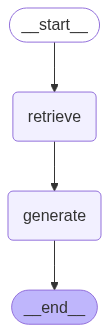

In [36]:
app


The `StateGraph` defines the workflow for processing each user message:

1. Start at the `retrieve` node, which finds relevant document chunks
2. Continue to the `generate` node, which creates a response using the retrieved context
3. The final result is automatically returned to the user

### Testing Our RAG Application

Let's test our RAG application with a multi-turn conversation:

In [ ]:
# Each run is associated with a thread ID (like a user session ID)
config = {"configurable": {"thread_id": "rag-chat"}}

# First user message (no prior memory; simple greeting)
response = app.invoke({"messages": [HumanMessage(content="My name is Umang.")]}, config)
print("Response 1: " + response["messages"][-1].content)

Response 1: Hello, Umang! How can I assist you today?


In [ ]:
# Second message: model now uses memory to recall user's name
response = app.invoke({"messages": [HumanMessage(content="What is my name?")]}, config)
print("Response 2: " + response["messages"][-1].content)

Response 2: Your name is Umang.


In [ ]:
# RAG question: answered using retrieved documents from the blog
response = app.invoke({"messages": [HumanMessage(content="What is Task Decomposition?")]}, config)
print("Response 3: " + response["messages"][-1].content)

Response 3: Task decomposition is the process of breaking down a complex task or problem into smaller, more manageable components or sub-tasks. This approach simplifies the execution and understanding of the task, making it easier to organize, prioritize, and tackle each part systematically. Task decomposition is commonly used in project management, software development, and problem-solving to improve efficiency and clarity.


In [ ]:
# Follow-up: model still has context of both memory and prior retrieved content
response = app.invoke({"messages": [HumanMessage(content="Can you elaborate on that?")]}, config)
print("Response 4: " + response["messages"][-1].content)

Response 4: Certainly! Task decomposition is a valuable technique that can be applied in various fields, including project management, software engineering, and even personal productivity. Here’s a more detailed look at its key aspects:

### 1. **Identifying the Main Task**
   - The process begins with clearly defining the main task or goal. This could be anything from launching a new product to writing a research paper.

### 2. **Breaking Down the Task**
   - The main task is then broken down into smaller, more manageable sub-tasks or components. Each sub-task should represent a specific part of the main task that can be completed independently.

### 3. **Defining Sub-Tasks**
   - Each sub-task should be clearly defined with its own objectives, timelines, and required resources. This clarity helps ensure that anyone involved understands what needs to be done.

### 4. **Prioritization and Organization**
   - Once the task is decomposed, the next step is to prioritize the sub-tasks base

## Working with Different Data Types

One of LangChain's strengths is its ability to work with many different data formats. Let's explore how to load and process other types of data.


### CSV Files

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path="sample_data/california_housing_train.csv")
docs = loader.load_and_split()

# Examine the loaded documents
print(docs[1])

page_content='longitude: -114.470000
latitude: 34.400000
housing_median_age: 19.000000
total_rooms: 7650.000000
total_bedrooms: 1901.000000
population: 1129.000000
households: 463.000000
median_income: 1.820000
median_house_value: 80100.000000' metadata={'source': 'sample_data/california_housing_train.csv', 'row': 1}


In [ ]:
print(docs[2])

page_content='longitude: -114.560000
latitude: 33.690000
housing_median_age: 17.000000
total_rooms: 720.000000
total_bedrooms: 174.000000
population: 333.000000
households: 117.000000
median_income: 1.650900
median_house_value: 85700.000000' metadata={'source': 'sample_data/california_housing_train.csv', 'row': 2}


LangChain's document loaders handle the complexities of different file formats and automatically convert them into a common document format that can be processed by the rest of the pipeline. Here we can see that the ```CSVLoader``` correctly split the documents by row and retained the column headers for each chunk to retain context. A simple text splitter would lose this valuable context starting in the second chunk.

### Other Document Types

LangChain provides loaders for many other data sources:

#### PDFs with OCR

```python
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.parsers import RapidOCRBlobParser

loader = PyPDFLoader(
    "./example_data/layout-parser-paper.pdf",
    mode="page",
    images_inner_format="markdown-img",
    images_parser=RapidOCRBlobParser(),
)
docs = loader.load()
```

#### JSON Files

```python
from langchain_community.document_loaders import JSONLoader

loader = JSONLoader(
    file_path="./example_data/document.json",
    jq_schema=".messages[].content",
    text_content=False,
)
docs = loader.load()
```

#### Multiple File Types

```python
from langchain_unstructured import UnstructuredLoader

file_paths = [
    "./example_data/layout-parser-paper.pdf",
    "./example_data/state_of_the_union.txt",
]
loader = UnstructuredLoader(file_paths)
docs = loader.load()
```

## Text Splitting Strategies

Processing long documents requires breaking them into smaller chunks. LangChain offers several text splitting approaches:

### RecursiveCharacterTextSplitter

This is the most versatile splitter, which recursively tries to split by different delimiters.

```python
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
texts = text_splitter.split_text(document)
```

### MarkdownHeaderTextSplitter

Specialized for Markdown documents, this splitter preserves the header structure.

```python
from langchain_text_splitters import MarkdownHeaderTextSplitter

markdown_document = "# Foo\n\n    ## Bar\n\nHi this is Jim\n\nHi this is Joe\n\n ### Boo \n\n Hi this is Lance \n\n ## Baz\n\n Hi this is Molly"
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_document)
```

### Semantic Chunk Splitting

This advanced splitter uses embeddings to detect natural semantic boundaries. If embeddings are sufficiently far apart, chunks are split. This chunker works by determining when to "break" apart sentences. This is done by looking for differences in embeddings between any two sentences. When that difference is past some threshold, then they are split. There are a few ways to determine what that threshold is, which are controlled by the breakpoint_threshold_type kwarg. The default way to split is based on percentile. In this method, all differences between sentences are calculated, and then any difference greater than the X percentile is split. The default value for X is 95.0. Standard deviation, interquartile and gradient are some other options. Read more about semantic chunk splitting here: https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb

```python
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

text_splitter = SemanticChunker(OpenAIEmbeddings(), breakpoint_threshold_type="percentile")
docs = text_splitter.create_documents([state_of_the_union])
```

## Advanced RAG Strategies

Beyond basic RAG, there are several techniques to enhance retrieval quality and response accuracy:

### HyDE (Hypothetical Document Embedding)

**HyDE** is an innovative approach that transforms query questions into hypothetical documents containing an answer. This helps bridge the semantic gap between queries and documents in the vector space.

Traditional retrieval methods often struggle with the semantic gap between short queries and longer, more detailed documents. HyDE addresses this by expanding the query into a full hypothetical document, potentially improving retrieval relevance by making the query representation more similar to the document representations in the vector space.

Let's implement a complete HyDE-enhanced RAG system:

In [ ]:
# Import necessary packages
import bs4
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.messages import HumanMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# --- Download example data ---
import urllib.request
from pathlib import Path

url = "https://arxiv.org/pdf/1706.03762.pdf"
dest = Path("data/Transformer_Attention_Is_All_You_Need.pdf")
dest.parent.mkdir(exist_ok=True)

if not dest.exists():
    urllib.request.urlretrieve(url, dest)
    print("Downloaded:", dest)
else:
    print("Already downloaded:", dest)

Already downloaded: data/Transformer_Attention_Is_All_You_Need.pdf


In [ ]:
# --- Initialize components ---
model = init_chat_model("gpt-4o", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

Like every loader we've seen so far, the ```PyPDFLoader``` also uses the loader.load() functionality. We then use a simple ```RecursiveCharacterTextSplitter``` to split the document.

In [ ]:
# --- Load and process PDF content ---
file_path = "data/Transformer_Attention_Is_All_You_Need.pdf"
loader = PyPDFLoader(file_path)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
_ = vector_store.add_documents(splits)

A good prompt becomes increasingly important when using advanced retrieval techniques. Here, we give the model instructions on what to do in the scenario where creating a document may not be necessary. We also provide it with valuable context that will allow the model to determine when to create hypothetical documents, and when to simply return the user's query. This allows us to minimize token usage and prevents the final model receiving the user query and context from hallucinating or responding incorrectly.

Similarly, the prompt for the final model should also be informative and provide instructions on how to interpret the information being passed to it.

One important thing to keep in mind is that the model that is generating hypothetical documents should be a decently large model that is capable and knowledgeable enough to create somewhat accurate results. A small model would likely not have enough world knowldge to provide good and factually correct hypothetical documents.

In [ ]:
# --- Define prompt templates ---
# Template for generating hypothetical documents
HyDE_prompt = PromptTemplate.from_template(
    """Given the user's question '{query}', generate a hypothetical document that directly answers the question.
    The document should be detailed and in-depth. The document size has to be exactly 1000 characters.

    You MUST generate a hypothetical document if the query is about ANY of the following topics:
    - Transformers
    - Attention mechanisms
    - Neural network architectures
    - The paper "Attention is all you need"
    - Self-attention
    - Machine translation
    - Encoder-decoder architecture
    - Sequence modeling

    If the user's query is a simple conversational question like "Hello", "What is my name?", "How are you?", or other introductory text, simply return the query exactly as it is with no other text."""
)

# Template for the final response generation
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant that answers questions about the paper "Attention is all you need".
    Use the context below to answer the question concisely. If the question is about the user's personal information
    (like their name), use the conversation history to provide accurate responses.

    Context:
    {context}"""),
    MessagesPlaceholder(variable_name="messages")
])

### Creating a Custom State Class

For HyDE, we need to track multiple pieces of information beyond just messages. Let's create a custom state class:

In [ ]:
from typing import List, Dict, Any, Optional
from pydantic import BaseModel, Field

class CustomState(BaseModel):
    """Custom state class to properly track all state elements"""
    messages: List[Any] = Field(default_factory=list)
    hypothetical_document: Optional[str] = None
    context: Optional[str] = None

This ```CustomState``` class:

- Uses Pydantic’s ```BaseModel```, which provides:
  - Automatic data validation (e.g., making sure messages is a list)
  - Serialization (e.g., converting the class to JSON for APIs or storage)
  - Easy default handling and error reporting when working with structured data

- Defines three fields to manage and track the application's state:
  - ```messages```: A list of items (e.g., chat messages or logs) representing the conversation history. It is initialized as an empty list by default using ```Field(default_factory=list)```.
  - The type ```List[Any]``` means it can store any kind of elements, offering flexibility.
  - ```hypothetical_document```: An optional string used to store a "HyDE-generated" document. Being Optional[str] means this value can either be a string or None (i.e., it may be absent).
  - ```context```: Another optional string that holds supporting or retrieved information.

Using a class like this keeps the program’s state cleanly organized and ensures the data is valid and easy to work with—especially important in applications involving conversations, document processing, or contextual reasoning.

### Implementing the HyDE Workflow

Now let's define the processing steps for our HyDE-enhanced RAG system:

In [ ]:
# --- Define LangGraph nodes (steps) ---

# Node 1: Hypothetical Document Generation
def generate_hypothetical_document(state: CustomState) -> Dict[str, Any]:
    """
    Generates a hypothetical 1000 character sized document based on the user's query.

    Parameters:
        state (CustomState): a custom state containing messages and other metadata

    Returns:
        dict: updated state with hypothetical_document
    """
    query = state.messages[-1].content
    prompt_text = HyDE_prompt.format(query=query)
    response = model.invoke(prompt_text)

    hypothetical_doc = response.content

    # Printing generated document
    print("\n--- Hypothetical Document (HyDE) ---\n")
    print(hypothetical_doc)
    print("\n--- End of HyDE ---\n")

    # Return updated state
    return {"hypothetical_document": hypothetical_doc}

# Node 2: Retriever step
def retrieve(state: CustomState) -> Dict[str, Any]:
    """
    Retrieves relevant documents from the vector store using the Hypothetical document as query.

    Parameters:
        state (CustomState): includes messages and hypothetical_document

    Returns:
        dict: updated state with context
    """
    hyde_query = state.hypothetical_document

    # Skip retrieval for simple queries that don't have meaningful hypothetical documents
    # Check if the hyde_query is identical or very similar to the original query
    # Print the document or information being passed to the secondary/final model
    query = state.messages[-1].content
    if hyde_query == query or len(hyde_query) < 30:
        context = "No specific context retrieved for basic queries."
        print("\n--- Hypothetical Document (HyDE) in Retrieval Step (Sanity Check)---\n")
        print(context)
        print("\n--- End of HyDE ---\n")
    else:
        # Retrieve relevant documents using the hypothetical document
        docs = vector_store.similarity_search(hyde_query)
        context = "\n\n".join(d.page_content for d in docs)
        print("\n--- Hypothetical Document (HyDE) in Retrieval Step (Sanity Check)---\n")
        print(hyde_query)
        print("\n--- End of HyDE ---\n")

    # Return updated state
    return {"context": context}

# Node 3: Generator step
def generate(state: CustomState) -> Dict[str, Any]:
    """
    Generates a response based on the retrieved context and full chat history.

    Parameters:
        state (CustomState): includes messages, hypothetical_document, and context

    Returns:
        dict: updated messages with assistant's reply
    """
    context = state.context
    prompt_msg = prompt.invoke({
        "context": context,
        "messages": state.messages  # full chat history
    })
    response = model.invoke(prompt_msg)  # generate response via LLM

    # Return only the messages key as we're only updating that part of the state
    return {"messages": state.messages + [response]}

### Assembling the HyDE-Enhanced RAG Pipeline

Finally, let's assemble these components into a complete workflow:

In [ ]:
# --- Construct the LangGraph pipeline ---

# Use our custom state class instead of MessagesState
builder = StateGraph(CustomState)

# Register nodes in the graph
builder.add_node("generate_hypothetical_document", generate_hypothetical_document)
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

# Set starting point
builder.set_entry_point("generate_hypothetical_document")

# Define transitions
builder.add_edge("generate_hypothetical_document", "retrieve")
builder.add_edge("retrieve", "generate")

# Enable conversation memory
memory = MemorySaver()
app = builder.compile(checkpointer=memory)

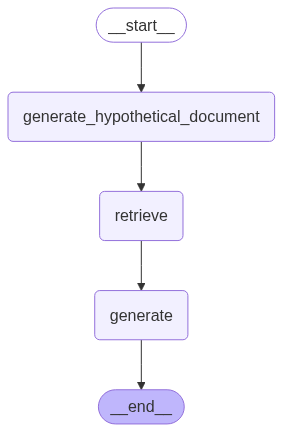

In [ ]:
app

In [ ]:
# --- Test the HyDE-enhanced RAG system ---
config = {"configurable": {"thread_id": "HyDE-rag"}}

# First user message
response = app.invoke({"messages": [HumanMessage(content="My name is Umang.")]}, config)
print("Response 1: " + response["messages"][-1].content)


--- Hypothetical Document (HyDE) ---

My name is Umang.

--- End of HyDE ---


--- Hypothetical Document (HyDE) in Retrieval Step (Sanity Check)---

No specific context retrieved for basic queries.

--- End of HyDE ---

Response 1: Nice to meet you, Umang! How can I assist you today?


In [ ]:
# Second message
response = app.invoke({"messages": response["messages"] + [HumanMessage(content="What is my name?")]}, config)
print("Response 2: " + response["messages"][-1].content)


--- Hypothetical Document (HyDE) ---

What is my name?

--- End of HyDE ---


--- Hypothetical Document (HyDE) in Retrieval Step (Sanity Check)---

No specific context retrieved for basic queries.

--- End of HyDE ---

Response 2: Your name is Umang.


In [ ]:
# RAG question
response = app.invoke({"messages": response["messages"] + [HumanMessage(content="What is Attention?")]}, config)
print("Response 3: " + response["messages"][-1].content)


--- Hypothetical Document (HyDE) ---

Attention is a mechanism used in neural networks to dynamically focus on relevant parts of input data, particularly beneficial in sequence modeling. Exemplified in the seminal paper "Attention is All You Need," this mechanism revolutionized architectures by enabling models to consider multiple parts of the sequence simultaneously, rather than sequentially. Attention mechanisms assign varying importance to different elements of a sequence, allowing models to efficiently handle tasks such as machine translation and language modeling.

There are multiple types of attention, including self-attention, where a sequence's elements attend to each other, capturing intricate dependencies within the sequence. This is crucial in transformers, a model that relies entirely on self-attention and feed-forward neural networks, forsaking traditional recurrence seen in earlier models like RNNs or LSTMs.

In the encoder-decoder architecture, often used in machine tra

In [ ]:
# Follow-up
response = app.invoke({"messages": response["messages"] + [HumanMessage(content="Can you elaborate on that?")]}, config)
print("Response 4: " + response["messages"][-1].content)


--- Hypothetical Document (HyDE) ---

The paper "Attention is All You Need," published in 2017 by Vaswani et al., revolutionized neural network architectures, particularly in natural language processing tasks like machine translation. The key innovation introduced was the Transformer model, which fundamentally relies on the self-attention mechanism. This mechanism allows the model to weigh the importance of different words in a sentence, irrespective of their positional relationships, overcoming the limitations of RNNs that process sequentially. The attention mechanism calculates a score for each word pair in a sequence, derived from queries, keys, and values. This approach enables the model to consider context comprehensively, improving translation accuracy. The architecture consists of an encoder and a decoder, both utilizing stacked layers of multi-head self-attention and position-wise fully connected feed-forward networks. Positional encodings are added to input data to give the m

### Other Advanced RAG Techniques

There are several other techniques that can improve RAG performance:

- **HyPE (Hypothetical Prompt Embeddings)**: Pre-computes hypothetical prompts during indexing, transforming retrieval into a question-question matching task. This avoids runtime synthetic answer generation, reducing computational overhead.

- **Hierarchical Indices**: Organizes information in a multi-level structure:
  1. Top-Level Summaries: Brief overviews of entire documents
  2. Mid-Level Overviews: More detailed summaries of subsections
  3. Detailed Chunks: Specific, granular pieces of information

  This structure enables more efficient and context-aware retrieval.

hierarchical_indices.svg

- GraphRAG: GraphRAG is an advanced question-answering system that combines the power of graph-based knowledge representation with retrieval-augmented generation. It processes input documents to create a rich knowledge graph, which is then used to enhance the retrieval and generation of answers to user queries. The system leverages natural language processing, machine learning, and graph theory to provide more accurate and contextually relevant responses.

  **Motivation**

  Traditional retrieval-augmented generation systems often struggle with maintaining context over long documents and making connections between related pieces of information. GraphRAG addresses these limitations by:

  Representing knowledge as an interconnected graph, allowing for better preservation of relationships between concepts.
  Enabling more intelligent traversal of information during the query process.
  Providing a visual representation of how information is connected and accessed during the answering process.

  GraphRAG often requires extensive knowledge of graph theory and custom solutions, though there seems to be some progress towards creating more straightforward implementations.

That completes our overview of RAG. There are many more augmentations and advanced techniques that we couldn't cover. For a more detailed description and implementations of these techniques, check out this amazing (and constantly updated!) repository: https://github.com/NirDiamant/RAG_Techniques